# Robustness of policies

## Re-evaluate under deep uncertainty

Combine the pareto set of solutions found for each scenario. Next, turn each solution into a policy object. If you have a very large number of policies, you can choose to down sample your policies in some reasoned way (*e.g.*, picking min and max on each objective, slicing across the pareto front with a particular step size). As a rule of thumb, try to limit the set of policies to at most 50. 

Re-evaluate the combined set of solutions over 1000 scenarios sampled using LHS.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ema_workbench.analysis import parcoords

from problem_formulation import get_model_for_problem_formulation
dike_model, planning_steps = get_model_for_problem_formulation(3)

C:\Users\thori\Anaconda3\envs\mbdm1\lib\site-packages\ema_workbench\analysis\prim.py:30: ImportWarning: altair based interactive inspection not available
  warnings.warn(("altair based interactive "


The results from the optimisation are read in. Only policies i.e. lever combinations are kept, that result in less than 0.01 expected deaths for A.5 Deventer. This ensures that all lever combinations that are considered for policies actually perform well over the worst case scenarios.

In [311]:
results = []
for i in range(5):
    results_scenario = pd.read_csv(f'outcomes/15k_results_optimisation_scenario{i}.csv')
    results_scenario = results_scenario[results_scenario['A.5_Expected Number of Deaths'] <= 0.01]
    results.append(results_scenario)

In [4]:
results[3].columns

Index(['Unnamed: 0', '0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1',
       '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1',
       '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2', 'EWS_DaysToThreat',
       'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
       'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
       'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
       'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2',
       'A.1 Total Costs', 'A.1_Expected Number of Deaths', 'A.2 Total Costs',
       'A.2_Expected Number of Deaths', 'A.3 Total Costs',
       'A.3_Expected Number of Deaths', 'A.4 Total Costs',
       'A.4_Expected Number of Deaths', 'A.5 Total Costs',
       'A.5_Expected Number of Deaths', 'RfR Total Costs',
       'Expected Evacuation Costs'],
      dtype='object')

Following, the results for the 4 other dike rings (non-Deventer) are added up. This is due to the comparison between Deventer and the rest. Results for dike ring 4 (Gorssel) are kept to be able to directly compare Deventer's results to those of its neighbour Gorssel.

In [5]:
for i in range(len(results)):
    results[i]['Other Areas Total Number of Deaths'] = 0  
    results[i]['Other Areas Total Costs'] = 0
    results[i]['Scenario number'] = i
    
    for area in range(1,5):
        results[i]['Other Areas Total Number of Deaths'] += results[i][f'A.{area}_Expected Number of Deaths']
        results[i]['Other Areas Total Costs'] += results[i][f'A.{area} Total Costs']
    
    results[i] = results[i].drop(['A.1 Total Costs', 'A.1_Expected Number of Deaths', 'A.2 Total Costs',
       'A.2_Expected Number of Deaths', 'A.3 Total Costs',
       'A.3_Expected Number of Deaths', 'Unnamed: 0'], axis=1)

In [313]:
combined_results = results[0].append([results[1], results[2], results[3], results[4]], ignore_index=True)

In [314]:
combined_results.sort_values('A.5_Expected Number of Deaths')

,Unnamed: 0,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,...,A.2 Total Costs,A.2_Expected Number of Deaths,A.3 Total Costs,A.3_Expected Number of Deaths,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
0,0,0,0,1,0,0,0,0,0,1,...,4.784270e+07,0.000000,9.966760e+06,0.001020,2.078505e+07,0.000000,1.462890e+08,0.000000,478900000.0,244.264995
2977,675,0,0,0,0,1,0,0,1,1,...,4.344032e+07,0.000843,2.216782e+07,0.000000,3.162307e+07,0.000000,1.354565e+08,0.000000,521600000.0,64.826822
2979,677,1,0,0,0,0,0,1,1,0,...,9.014392e+07,0.000000,2.029929e+07,0.000000,2.292801e+07,0.000000,1.027413e+08,0.000000,765700000.0,0.000000
2981,679,0,0,0,0,0,0,0,1,0,...,1.007594e+08,0.000000,8.094809e+07,0.009122,2.155622e+07,0.000000,1.343536e+08,0.000000,151900000.0,308.172204
2987,687,0,1,0,0,1,0,0,1,1,...,4.645853e+07,0.003079,2.029929e+07,0.000000,3.284906e+07,0.000000,1.354565e+08,0.000000,606200000.0,968.138101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
630,747,0,0,0,0,0,0,1,0,1,...,2.120392e+08,0.000000,9.983652e+06,0.003068,4.075115e+07,0.000182,2.028888e+08,0.009986,61400000.0,1036.546200
709,859,0,0,0,0,0,0,1,0,1,...,1.879960e+08,0.000000,5.373436e+07,0.001023,2.038439e+07,0.000182,2.101657e+08,0.009986,61400000.0,968.852288
765,934,0,0,0,0,0,0,1,0,1,...,9.342700e+07,0.000000,4.920439e+07,0.001023,3.250037e+07,0.000182,2.281527e+08,0.009986,61400000.0,968.852288
723,874,0,0,0,0,0,0,1,0,0,...,1.773315e+08,0.000000,9.799391e+07,0.000000,2.038439e+07,0.000182,2.042425e+08,0.009986,30700000.0,935.005333


From the 5 scenarios that were put into the optimisation (see notebook multi-scenario MORDM.ipynb), the maximum i.e. worst values for each of those scenarios for each column as well as the minimum i.e. best outcomes for those 5 optimised scenarios are taken. Then, the experiments matching those outcomes are are stored. 

In [7]:
outcomes_array = ['A.4 Total Costs', 
                  'A.4_Expected Number of Deaths',
                  'A.5 Total Costs',
                  'A.5_Expected Number of Deaths', 
                  'RfR Total Costs',
                  'Expected Evacuation Costs',
                  'Other Areas Total Number of Deaths',
                  'Other Areas Total Costs']


lever_array = outcomes_array + ['Scenario number']

result_best_worst_scenarios = []
for i in range(len(results)):
    result_best_worst = []
    result_worst = results[i].loc[results[i][outcomes_array].idxmax()]

    result_best = results[i].loc[results[i][outcomes_array].idxmin()]

    result_best_worst = result_best.append(result_worst)
    
    result_best_worst = result_best_worst.drop(lever_array, axis=1)
    result_best_worst_scenarios.append(result_best_worst)

In [8]:
len(result_best_worst_scenarios)

5

In [9]:
result_best_worst_all = result_best_worst_scenarios[0].append([result_best_worst_scenarios[1], result_best_worst_scenarios[2], result_best_worst_scenarios[3], result_best_worst_scenarios[4]], ignore_index=True)
result_best_worst_all

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
0,0,0,1,0,0,0,0,0,1,1,...,3,0,2,0,4,0,0,5,6,2
1,0,0,1,0,0,0,0,0,1,1,...,3,0,0,0,4,0,4,10,1,5
2,0,1,0,0,0,0,0,0,0,1,...,1,0,0,0,4,6,6,7,0,0
3,0,0,1,0,0,0,0,0,1,1,...,3,0,0,0,4,0,4,10,1,5
4,0,0,0,0,0,0,0,0,0,0,...,6,3,3,3,7,2,0,9,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0,1,0,1,0,0,1,1,0,0,...,0,2,0,0,3,0,2,6,3,3
76,1,1,1,1,0,1,1,1,1,1,...,2,4,1,7,2,0,0,7,3,6
77,0,0,1,0,0,0,0,0,1,0,...,0,1,0,7,0,0,0,6,2,7
78,0,0,1,0,0,0,1,0,0,0,...,2,0,0,1,6,0,0,9,2,2


It results, that some experiments are the same. Duplicates will be removed. Then, out of those experiments policies are created. 

In [11]:
duplicateDFRow = result_best_worst_all[result_best_worst_all.duplicated()]
result_best_worst_all_no_duplicates = result_best_worst_all.drop(duplicateDFRow.index)

In [12]:
result_best_worst_all_no_duplicates

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
0,0,0,1,0,0,0,0,0,1,1,...,3,0,2,0,4,0,0,5,6,2
1,0,0,1,0,0,0,0,0,1,1,...,3,0,0,0,4,0,4,10,1,5
2,0,1,0,0,0,0,0,0,0,1,...,1,0,0,0,4,6,6,7,0,0
4,0,0,0,0,0,0,0,0,0,0,...,6,3,3,3,7,2,0,9,4,2
5,0,1,1,0,0,0,1,0,0,1,...,5,1,6,0,4,2,0,7,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0,1,0,1,0,0,1,1,0,0,...,0,2,0,0,3,0,2,6,3,3
76,1,1,1,1,0,1,1,1,1,1,...,2,4,1,7,2,0,0,7,3,6
77,0,0,1,0,0,0,0,0,1,0,...,0,1,0,7,0,0,0,6,2,7
78,0,0,1,0,0,0,1,0,0,0,...,2,0,0,1,6,0,0,9,2,2


In [13]:
from ema_workbench import Policy

policies = []
for j, row in result_best_worst_all_no_duplicates.iterrows():
        policy = Policy(f'scenario option {j}', **row.to_dict())
        policies.append(policy)

These policies represent the policies that perform best and worst over the worst-case scenarios but still meet the set threshold of 0.01 deaths in Deventer. 1000 scenarios are run with these policies to explore each policy's robustness.

In [18]:
from ema_workbench import (MultiprocessingEvaluator)
from ema_workbench.util import ema_logging

ema_logging.log_to_stderr(level = "NOTSET")


with MultiprocessingEvaluator(dike_model) as evaluator:
    reeevaluation_results = evaluator.perform_experiments(10, policies=policies)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 10 scenarios * 66 policies * 1 model(s) = 660 experiments
[MainProcess/DEBUG] 1 cases completed
[MainProcess/DEBUG] storing A.1 Total Costs
[MainProcess/DEBUG] storing A.1_Expected Number of Deaths
[MainProcess/DEBUG] storing A.2 Total Costs
[MainProcess/DEBUG] storing A.2_Expected Number of Deaths
[MainProcess/DEBUG] storing A.3 Total Costs
[MainProcess/DEBUG] storing A.3_Expected Number of Deaths
[MainProcess/DEBUG] storing A.4 Total Costs
[MainProcess/DEBUG] storing A.4_Expected Number of Deaths
[MainProcess/DEBUG] storing A.5 Total Costs
[MainProcess/DEBUG] storing A.5_Expected Number of Deaths
[MainProcess/DEBUG] storing RfR Total Costs
[MainProcess/DEBUG] storing Expected Evacuation Costs
[MainProcess/DEBUG] 2 cases completed
[MainProcess/DEBUG] storing A.1 Total Costs
[MainProcess/DEBUG] storing A.1_Expected Number of Deaths
[MainProcess/DEBUG] storing A.2 Total Costs
[MainProcess/DEBUG] storing A.2_Expected Number of

In [24]:
experiments = reeevaluation_results[0]
results = pd.DataFrame(reeevaluation_results[1])

In [25]:
results.to_csv('./outcomes/reevaluation_promising_policies_results.csv')
experiments.to_csv('./outcomes/reevaluation_promising_experiments.csv')

In [289]:
results_load = pd.read_csv('./outcomes/reevaluation_promising_policies_results.csv')
experiments_load = pd.read_csv('./outcomes/reevaluation_promising_experiments.csv')

In [261]:
results_load

,Unnamed: 0,A.1 Total Costs,A.1_Expected Number of Deaths,A.2 Total Costs,A.2_Expected Number of Deaths,A.3 Total Costs,A.3_Expected Number of Deaths,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
0,0,1.876591e+08,0.003849,4.978470e+07,0.000337,9.262480e+07,0.020368,9.695195e+06,0.000000,1.242279e+08,0.0,735000000.0,6510.069154
1,1,1.540026e+08,0.000000,3.918009e+08,0.040629,2.216782e+07,0.000000,9.695195e+06,0.000000,1.242279e+08,0.0,735000000.0,26694.874146
2,2,1.540026e+08,0.000000,1.477499e+08,0.010005,2.216782e+07,0.000000,9.695195e+06,0.000000,1.242279e+08,0.0,735000000.0,6081.861067
3,3,1.540026e+08,0.000000,5.584749e+07,0.001365,2.216782e+07,0.000000,9.695195e+06,0.000000,1.242279e+08,0.0,735000000.0,754.377861
4,4,1.540026e+08,0.000000,6.801229e+07,0.002470,4.994227e+07,0.007128,9.695195e+06,0.000000,1.242279e+08,0.0,735000000.0,3198.881920
...,...,...,...,...,...,...,...,...,...,...,...,...,...
655,655,1.326461e+08,0.000000,2.106806e+08,0.000000,1.196909e+08,0.000000,5.056398e+07,0.004046,1.643440e+08,0.0,115300000.0,810.461459
656,656,1.326461e+08,0.000000,2.106806e+08,0.000000,1.196909e+08,0.000000,1.265331e+08,0.015275,1.643440e+08,0.0,115300000.0,3518.764246
657,657,1.326461e+08,0.000000,2.110890e+08,0.000110,2.900200e+08,0.079100,1.105718e+08,0.010192,1.643440e+08,0.0,115300000.0,5179.928038
658,658,1.326461e+08,0.000000,2.118950e+08,0.000321,1.196909e+08,0.000000,3.621049e+07,0.001399,1.643440e+08,0.0,115300000.0,250.625258


In [296]:
experiments_load

,Unnamed: 0,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model
0,0,118.0,240.189839,1.5,0.136262,339.916770,10.0,0.838754,235.411771,10.0,...,0.0,4.0,0.0,0.0,5.0,6.0,2.0,0,scenario option 0,dikesnet
1,1,58.0,133.232521,1.0,0.944069,54.579037,10.0,0.070831,167.650382,1.5,...,0.0,4.0,0.0,0.0,5.0,6.0,2.0,1,scenario option 0,dikesnet
2,2,48.0,218.762338,1.0,0.652216,269.297376,1.5,0.189283,326.215036,1.5,...,0.0,4.0,0.0,0.0,5.0,6.0,2.0,2,scenario option 0,dikesnet
3,3,26.0,95.854746,1.0,0.878114,307.270852,1.0,0.592350,263.570505,1.0,...,0.0,4.0,0.0,0.0,5.0,6.0,2.0,3,scenario option 0,dikesnet
4,4,127.0,308.544612,10.0,0.588620,138.150197,10.0,0.495102,288.204436,10.0,...,0.0,4.0,0.0,0.0,5.0,6.0,2.0,4,scenario option 0,dikesnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655,655,1.0,280.970834,1.0,0.702963,180.984587,1.0,0.932094,208.893984,1.0,...,9.0,1.0,1.0,7.0,10.0,7.0,1.0,5,scenario option 79,dikesnet
656,656,71.0,80.869602,10.0,0.341615,201.670961,1.5,0.671292,142.549806,1.0,...,9.0,1.0,1.0,7.0,10.0,7.0,1.0,6,scenario option 79,dikesnet
657,657,27.0,42.455510,1.5,0.058490,230.964940,1.0,0.380375,121.057633,10.0,...,9.0,1.0,1.0,7.0,10.0,7.0,1.0,7,scenario option 79,dikesnet
658,658,90.0,344.200582,1.5,0.296880,89.923268,10.0,0.270746,68.977454,1.0,...,9.0,1.0,1.0,7.0,10.0,7.0,1.0,8,scenario option 79,dikesnet


### Maximin
Maximin is taking into account the worst case scenario the worst thing that could happen.

"the maximin metric has a very high level of intrinsic risk aversion, as its calculation is only based on the worst performance over all scenarios considered (Table 3), leading to a very conservative solution (Bertsimas & Sim, 2004). Similarly, the minimax regret metric assumes that the selected decision alternative will have the largest regret possible, as its calculation is based on the worst-case relative performance" https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2017EF000649


In [262]:
results_load['Other Areas Total Number of Deaths'] = 0  
results_load['Other Areas Total Costs'] = 0

for area in range(1,5):
    results_load['Other Areas Total Number of Deaths'] += results_load[f'A.{area}_Expected Number of Deaths']
    results_load['Other Areas Total Costs'] += results_load[f'A.{area} Total Costs']

results_load = results_load.drop(['A.1 Total Costs', 'A.1_Expected Number of Deaths', 'A.2 Total Costs',
   'A.2_Expected Number of Deaths', 'A.3 Total Costs',
   'A.3_Expected Number of Deaths', 'Unnamed: 0'], axis=1)



result_worst_reevaluation = results_load.loc[results_load[['A.5 Total Costs','A.5_Expected Number of Deaths']].idxmax()]

experiment_worst_reevaluation = experiments_load.iloc[result_worst_reevaluation.index].reset_index()

In [263]:
policy_outcomes_maximin = results_load
policy_outcomes_maximin['policy'] = experiments_load['policy'] 
policy_outcomes_maximin['scenario'] = experiments_load['scenario'] 

least_pref = pd.DataFrame()
for outcome in outcomes_array:
    least_pref[outcome] = policy_outcomes_maximin.groupby(['policy']).max()[outcome]


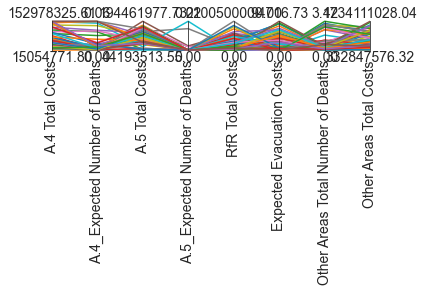

In [264]:
limits = parcoords.get_limits(least_pref)
axes = parcoords.ParallelAxes(limits)
axes.plot(least_pref)

In [265]:
worst_policies = []

for i in range(len(policies)):
    for j in range(len(experiment_worst_reevaluation)):
        if policies[i].name == experiment_worst_reevaluation['policy'][j]:
            worst_policies.append(policies[i])


In [266]:
worst_policies[1].name

'scenario option 30'

In [267]:
result_worst_reevaluation

,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,Other Areas Total Number of Deaths,Other Areas Total Costs
200,4.654264e+07,0.000000,1.944620e+08,0.002919,1.244000e+09,1725.25572,0.000000,5.031928e+08
240,1.937838e+07,0.004416,6.113056e+07,0.020442,0.000000e+00,0.00000,0.065433,2.010596e+08


In [268]:
worst_policies

[Policy({'0_RfR 0': 0, '0_RfR 1': 0, '0_RfR 2': 0, '1_RfR 0': 1, '1_RfR 1': 1, '1_RfR 2': 1, '2_RfR 0': 1, '2_RfR 1': 1, '2_RfR 2': 1, '3_RfR 0': 0, '3_RfR 1': 1, '3_RfR 2': 1, '4_RfR 0': 0, '4_RfR 1': 0, '4_RfR 2': 1, 'EWS_DaysToThreat': 3, 'A.1_DikeIncrease 0': 6, 'A.1_DikeIncrease 1': 4, 'A.1_DikeIncrease 2': 0, 'A.2_DikeIncrease 0': 9, 'A.2_DikeIncrease 1': 1, 'A.2_DikeIncrease 2': 6, 'A.3_DikeIncrease 0': 8, 'A.3_DikeIncrease 1': 2, 'A.3_DikeIncrease 2': 4, 'A.4_DikeIncrease 0': 4, 'A.4_DikeIncrease 1': 10, 'A.4_DikeIncrease 2': 3, 'A.5_DikeIncrease 0': 4, 'A.5_DikeIncrease 1': 9, 'A.5_DikeIncrease 2': 9}),
 Policy({'0_RfR 0': 0, '0_RfR 1': 0, '0_RfR 2': 0, '1_RfR 0': 0, '1_RfR 1': 0, '1_RfR 2': 0, '2_RfR 0': 0, '2_RfR 1': 0, '2_RfR 2': 0, '3_RfR 0': 0, '3_RfR 1': 0, '3_RfR 2': 0, '4_RfR 0': 0, '4_RfR 1': 0, '4_RfR 2': 0, 'EWS_DaysToThreat': 0, 'A.1_DikeIncrease 0': 5, 'A.1_DikeIncrease 1': 0, 'A.1_DikeIncrease 2': 1, 'A.2_DikeIncrease 0': 0, 'A.2_DikeIncrease 1': 0, 'A.2_DikeIncr

### Minimax Regret Criterion
The Minimax Regret Criterion is a technique used to make decisions under uncertainty. The context of a decision making process under uncertainty, a decision maker is faced to uncertain states of nature and a number of decision alternatives that can be chosen. The decision made and the final state of nature (which the decision maker does not know beforehand) determines the payoff.

Under this Minimax Regret Criterion, the decision maker calculates the maximum opportunity loss values (or also known as regret) for each alternative, and then she chooses the decision that has the lowest maximum regret.

The regret or opportunity loss for a specific alternative, at a given state of nature, is how much we lose by choosing that alternative and not the optimal alternative, given that state of nature (if the current alternative IS the optima alternative, then the opportunity loss for that alternative, given the state of nature, is 0).

https://mathcracker.com/minimax-regret-criterion-calculator

In [269]:
results_load.head(1)

,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,Other Areas Total Number of Deaths,Other Areas Total Costs,policy,scenario
0,9.695195e+06,0.0,1.242279e+08,0.0,735000000.0,6510.069154,0.024553,3.397638e+08,scenario option 0,0


In [270]:
results_load

,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,Other Areas Total Number of Deaths,Other Areas Total Costs,policy,scenario
0,9.695195e+06,0.000000,1.242279e+08,0.0,735000000.0,6510.069154,0.024553,3.397638e+08,scenario option 0,0
1,9.695195e+06,0.000000,1.242279e+08,0.0,735000000.0,26694.874146,0.040629,5.776665e+08,scenario option 0,1
2,9.695195e+06,0.000000,1.242279e+08,0.0,735000000.0,6081.861067,0.010005,3.336155e+08,scenario option 0,2
3,9.695195e+06,0.000000,1.242279e+08,0.0,735000000.0,754.377861,0.001365,2.417131e+08,scenario option 0,3
4,9.695195e+06,0.000000,1.242279e+08,0.0,735000000.0,3198.881920,0.009598,2.816523e+08,scenario option 0,4
...,...,...,...,...,...,...,...,...,...,...
655,5.056398e+07,0.004046,1.643440e+08,0.0,115300000.0,810.461459,0.004046,5.135816e+08,scenario option 79,5
656,1.265331e+08,0.015275,1.643440e+08,0.0,115300000.0,3518.764246,0.015275,5.895507e+08,scenario option 79,6
657,1.105718e+08,0.010192,1.643440e+08,0.0,115300000.0,5179.928038,0.089402,7.443270e+08,scenario option 79,7
658,3.621049e+07,0.001399,1.643440e+08,0.0,115300000.0,250.625258,0.001721,5.004425e+08,scenario option 79,8


In [271]:
policy_outcomes = results_load
policy_outcomes_regret = results_load.copy()
policy_outcomes_regret['scenario'] = experiments_load['scenario']
policy_outcomes_regret['policy'] = experiments_load['policy']

most_pref = pd.DataFrame()
for outcome in outcomes_array:
    most_pref[outcome] = policy_outcomes_regret.groupby(['scenario']).min()[outcome]

most_pref.reset_index(inplace=True)

In [272]:
most_pref

,scenario,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,Other Areas Total Number of Deaths,Other Areas Total Costs
0,0,2.220221e+06,0.0,4.419351e+07,0.0,0.0,0.0,0.000000,9.041835e+07
1,1,0.000000e+00,0.0,3.667668e+07,0.0,0.0,0.0,0.000000,1.463068e+08
2,2,0.000000e+00,0.0,3.667668e+07,0.0,0.0,0.0,0.000000,1.407488e+08
3,3,3.679440e+06,0.0,3.667668e+07,0.0,0.0,0.0,0.000000,7.535839e+07
4,4,1.240193e+06,0.0,3.667668e+07,0.0,0.0,0.0,0.000000,9.797991e+07
5,5,7.332080e+06,0.0,3.667668e+07,0.0,0.0,0.0,0.000000,6.551667e+07
6,6,1.505477e+07,0.0,3.667668e+07,0.0,0.0,0.0,0.000000,1.032016e+08
7,7,6.923755e+06,0.0,3.667668e+07,0.0,0.0,0.0,0.000102,2.941583e+08
8,8,7.332080e+06,0.0,3.667668e+07,0.0,0.0,0.0,0.000000,1.477427e+08
9,9,0.000000e+00,0.0,3.667668e+07,0.0,0.0,0.0,0.000000,6.943377e+07


In [273]:
policy_outcomes

,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,Other Areas Total Number of Deaths,Other Areas Total Costs,policy,scenario
0,9.695195e+06,0.000000,1.242279e+08,0.0,735000000.0,6510.069154,0.024553,3.397638e+08,scenario option 0,0
1,9.695195e+06,0.000000,1.242279e+08,0.0,735000000.0,26694.874146,0.040629,5.776665e+08,scenario option 0,1
2,9.695195e+06,0.000000,1.242279e+08,0.0,735000000.0,6081.861067,0.010005,3.336155e+08,scenario option 0,2
3,9.695195e+06,0.000000,1.242279e+08,0.0,735000000.0,754.377861,0.001365,2.417131e+08,scenario option 0,3
4,9.695195e+06,0.000000,1.242279e+08,0.0,735000000.0,3198.881920,0.009598,2.816523e+08,scenario option 0,4
...,...,...,...,...,...,...,...,...,...,...
655,5.056398e+07,0.004046,1.643440e+08,0.0,115300000.0,810.461459,0.004046,5.135816e+08,scenario option 79,5
656,1.265331e+08,0.015275,1.643440e+08,0.0,115300000.0,3518.764246,0.015275,5.895507e+08,scenario option 79,6
657,1.105718e+08,0.010192,1.643440e+08,0.0,115300000.0,5179.928038,0.089402,7.443270e+08,scenario option 79,7
658,3.621049e+07,0.001399,1.643440e+08,0.0,115300000.0,250.625258,0.001721,5.004425e+08,scenario option 79,8


In [196]:
for i in range(len(policy_outcomes_regret)):
    for j in range(len(most_pref)):
        if policy_outcomes_regret['scenario'][i] == most_pref['scenario'][j]:
            for outcome in outcomes_array:
                policy_outcomes_regret[outcome][i] -= most_pref[outcome][j]

C:\Users\Ted\Anaconda3\envs\MBDM\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [197]:
policy_outcomes_regret

,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,Other Areas Total Number of Deaths,Other Areas Total Costs,scenario,policy
0,7.474974e+06,0.000000,8.003435e+07,0.0,735000000.0,6510.069154,0.024553,2.493454e+08,0,scenario option 0
1,9.695195e+06,0.000000,8.755119e+07,0.0,735000000.0,26694.874146,0.040629,4.313597e+08,1,scenario option 0
2,9.695195e+06,0.000000,8.755119e+07,0.0,735000000.0,6081.861067,0.010005,1.928667e+08,2,scenario option 0
3,6.015755e+06,0.000000,8.755119e+07,0.0,735000000.0,754.377861,0.001365,1.663547e+08,3,scenario option 0
4,8.455003e+06,0.000000,8.755119e+07,0.0,735000000.0,3198.881920,0.009598,1.836724e+08,4,scenario option 0
...,...,...,...,...,...,...,...,...,...,...
655,4.323190e+07,0.004046,1.276673e+08,0.0,115300000.0,810.461459,0.004046,4.480649e+08,5,scenario option 79
656,1.114783e+08,0.015275,1.276673e+08,0.0,115300000.0,3518.764246,0.015275,4.863492e+08,6,scenario option 79
657,1.036481e+08,0.010192,1.276673e+08,0.0,115300000.0,5179.928038,0.089300,4.501687e+08,7,scenario option 79
658,2.887841e+07,0.001399,1.276673e+08,0.0,115300000.0,250.625258,0.001721,3.526998e+08,8,scenario option 79


In [276]:
policy_outcomes_regret1 = policy_outcomes_regret.groupby(['policy']).max().drop('scenario', axis=1)
#policy_outcomes_regret['policy'] = policy_outcomes_regret.index()
policy_outcomes_regret

,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,Other Areas Total Number of Deaths,Other Areas Total Costs
policy,,,,,,,,
scenario option 0,2.187102e+07,0.000638,1.242279e+08,0.000000,7.350000e+08,86635.521991,0.295637,2.751269e+09
scenario option 1,3.544169e+07,0.000761,1.462890e+08,0.000000,4.789000e+08,79474.255238,0.253362,1.976065e+09
scenario option 10,3.075362e+07,0.000519,1.354780e+08,0.002621,7.777000e+08,54357.783388,0.253222,3.157775e+09
scenario option 11,6.051835e+07,0.003618,1.396070e+08,0.000000,6.140000e+07,36014.897731,0.925369,3.026670e+09
scenario option 12,3.403238e+07,0.001045,9.043017e+07,0.000000,1.203000e+09,42300.169051,0.248149,1.655050e+09
...,...,...,...,...,...,...,...,...
scenario option 77,1.461326e+08,0.007532,1.318342e+08,0.000000,1.153000e+08,49309.297956,0.184238,1.568075e+09
scenario option 78,2.550197e+07,0.006508,1.303402e+08,0.000000,2.365000e+08,0.000000,2.507219,2.735536e+09
scenario option 79,1.265331e+08,0.015275,1.643440e+08,0.000000,1.153000e+08,5179.928038,0.089402,7.443270e+08


In [211]:
short_names = ['A.4_TC', 'A.4_Deaths', 'A.5_TC', 'A.5_Deaths', 'RfR Costs', 'Evac C', 'OTD', 'OTC']
policy_outcomes_regret = policy_outcomes_regret.set_axis(short_names, axis=1)
policy_outcomes_regret = policy_outcomes_regret.reindex(columns = ['A.4_Deaths', 'A.5_Deaths', 'OTD', 'A.4_TC', 'A.5_TC', 'OTC', 'RfR Costs', 'Evac C'])
policy_outcomes_regret = policy_outcomes_regret.groupby(['policy']).max()


from sklearn import preprocessing

x = policy_outcomes_regret.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
policy_outcomes_regret_norm = pd.DataFrame(x_scaled)


policy_outcomes_regret_norm = policy_outcomes_regret_norm.set_axis(short_names, axis=1)
policy_outcomes_regret_norm = policy_outcomes_regret_norm.reindex(columns = ['A.4_Deaths', 'A.5_Deaths', 'OTD', 'A.4_TC', 'A.5_TC', 'OTC', 'RfR Costs', 'Evac C'])


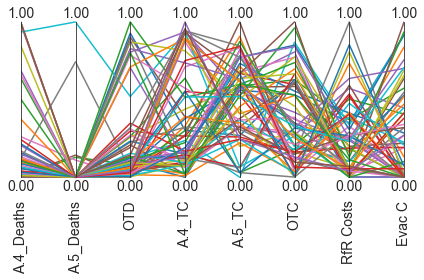

In [212]:

limits = parcoords.get_limits(policy_outcomes_regret_norm)
axes = parcoords.ParallelAxes(limits)
axes.plot(policy_outcomes_regret_norm)

In [234]:
todrop = []
for i in range(len(policy_outcomes_regret_norm)):
    for j in range(len(policy_outcomes_regret_norm)):
        if j == i:
            pass
        else:
            dominated = policy_outcomes_regret_norm.iloc[i,:] >= policy_outcomes_regret_norm.iloc[j,:]
            #print(dominated.sum())
            if dominated.sum() == len(policy_outcomes_regret_norm.columns):
                todrop.append(i)


In [241]:
policy_outcomes_regret_norm.drop(np.unique(todrop))

,A.4_Deaths,A.5_Deaths,OTD,A.4_TC,A.5_TC,OTC,RfR Costs,Evac C
0,0.010170,0.000000,0.094737,0.000000,0.560655,0.531466,0.349917,0.914680
1,0.012131,0.000000,0.081185,0.081872,0.715197,0.348290,0.227993,0.839073
2,0.008279,0.128220,0.081140,0.081872,0.586807,0.627521,0.370245,0.573898
3,0.057675,0.000000,0.296618,0.264063,0.668388,0.596542,0.029231,0.380238
4,0.016658,0.000000,0.079513,0.068528,0.323896,0.272437,0.572721,0.446597
5,0.000000,0.000000,0.901843,0.388612,0.323896,0.608314,0.057701,0.000000
6,0.132371,0.000000,0.039982,0.872925,0.323896,0.293227,0.029231,0.190926
7,0.117568,0.742943,0.047685,0.884942,0.622058,0.208175,0.103690,0.547203
8,0.000000,0.000000,0.257901,0.438250,0.587543,0.161664,0.057701,0.000000
9,0.003491,0.000000,0.124290,0.236315,0.000000,0.868917,0.335301,0.917236


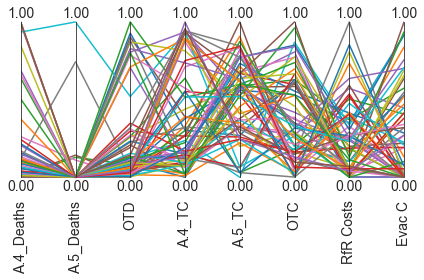

In [242]:
limits = parcoords.get_limits(policy_outcomes_regret_norm)
axes = parcoords.ParallelAxes(limits)
axes.plot(policy_outcomes_regret_norm)

In [244]:
policy_outcomes_regret_norm_4vs5 = policy_outcomes_regret_norm[['A.4_Deaths', 'A.5_Deaths', 'A.4_TC', 'A.5_TC']]
policy_outcomes_regret_norm_restvs5 = policy_outcomes_regret_norm[['A.5_Deaths', 'OTD', 'A.5_TC', 'OTC', 'RfR Costs', 'Evac C']]

In [248]:
def dominate(policy_outcomes_regret_norm):
    todrop = []
    for i in range(len(policy_outcomes_regret_norm)):
        for j in range(len(policy_outcomes_regret_norm)):
            if j == i:
                pass
            else:
                dominated = policy_outcomes_regret_norm.iloc[i,:] >= policy_outcomes_regret_norm.iloc[j,:]
                #print(dominated.sum())
                if dominated.sum() == len(policy_outcomes_regret_norm.columns):
                    todrop.append(i)
    return np.unique(todrop)

In [251]:
dominate4vs5 = dominate(policy_outcomes_regret_norm_4vs5)

In [255]:
policy_outcomes_regret_norm_4vs5 = policy_outcomes_regret_norm_4vs5.drop(dominate4vs5)

In [298]:
index_of_policies = policy_outcomes_regret_norm_4vs5.index.values
policy_names = policy_outcomes_regret.iloc[index_of_policies,:].index.values

policies_interesting = []
for i in range(len(policies)):
    for j in range(len(policy_names)):
        if policies[i].name == policy_names[j]:
            policies_interesting.append(policies[i])

In [305]:
policies_interesting

[Policy({'0_RfR 0': 0, '0_RfR 1': 0, '0_RfR 2': 1, '1_RfR 0': 0, '1_RfR 1': 0, '1_RfR 2': 0, '2_RfR 0': 0, '2_RfR 1': 0, '2_RfR 2': 1, '3_RfR 0': 1, '3_RfR 1': 1, '3_RfR 2': 1, '4_RfR 0': 0, '4_RfR 1': 0, '4_RfR 2': 1, 'EWS_DaysToThreat': 4, 'A.1_DikeIncrease 0': 1, 'A.1_DikeIncrease 1': 4, 'A.1_DikeIncrease 2': 6, 'A.2_DikeIncrease 0': 0, 'A.2_DikeIncrease 1': 0, 'A.2_DikeIncrease 2': 3, 'A.3_DikeIncrease 0': 0, 'A.3_DikeIncrease 1': 2, 'A.3_DikeIncrease 2': 0, 'A.4_DikeIncrease 0': 4, 'A.4_DikeIncrease 1': 0, 'A.4_DikeIncrease 2': 0, 'A.5_DikeIncrease 0': 5, 'A.5_DikeIncrease 1': 6, 'A.5_DikeIncrease 2': 2}),
 Policy({'0_RfR 0': 0, '0_RfR 1': 1, '0_RfR 2': 0, '1_RfR 0': 0, '1_RfR 1': 0, '1_RfR 2': 0, '2_RfR 0': 0, '2_RfR 1': 0, '2_RfR 2': 0, '3_RfR 0': 1, '3_RfR 1': 1, '3_RfR 2': 1, '4_RfR 0': 0, '4_RfR 1': 0, '4_RfR 2': 1, 'EWS_DaysToThreat': 3, 'A.1_DikeIncrease 0': 0, 'A.1_DikeIncrease 1': 0, 'A.1_DikeIncrease 2': 0, 'A.2_DikeIncrease 0': 1, 'A.2_DikeIncrease 1': 0, 'A.2_DikeIncre

In [291]:
policies_found

,Unnamed: 0,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
656,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
657,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


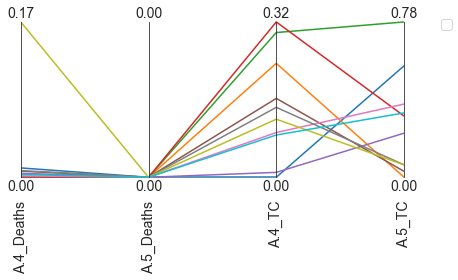

In [257]:
limits = parcoords.get_limits(policy_outcomes_regret_norm_4vs5)
axes = parcoords.ParallelAxes(limits)
axes.plot(policy_outcomes_regret_norm_4vs5)
axes.legend()

In [ ]:
dominaterestvs5 = dominate(policy_outcomes_regret_norm_restvs5)